<a href="https://colab.research.google.com/github/divyabala-ai/author-text-classification/blob/main/author_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install transformers datasets tensorflow

In [ ]:
# === Imports ===
import os
os.environ["WANDB_DISABLED"] = "true"

import re
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
from gensim.models import Word2Vec
from datasets import Dataset

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Download NLTK Data ===
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# Copy the contents of AuthorClassification folder from Google Drive to Colab
!cp -rv /content/drive/MyDrive/author_classification /content/

In [ ]:
# Preprocess all files Using NLTK

# Initialize the NLTK lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    # Remove stopwords and non-alphabetical words, and lemmatize
    cleaned_words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word.isalpha() and word not in stop_words and len(word) > 2
    ]
    return cleaned_words

# Define the path to the folder containing the books
folder_path = '/content/author_classification/'

# Initialize dictionaries to store preprocessed books by author
preprocessed_books = {}

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):  # Make sure to process only .txt files
        # Split filename to get author name
        author_name = filename.split('__')[0]

        # Read the content of the book file
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()

        # Preprocess the text
        cleaned_words = preprocess_text(text)

        # Add the cleaned words to the preprocessed_books dictionary
        if author_name not in preprocessed_books:
            preprocessed_books[author_name] = []

        preprocessed_books[author_name].append(cleaned_words)

# Now you can check the structure of your preprocessed data
print("Preprocessed books:", preprocessed_books)


In [ ]:
# Creating the dataset - Split each book into 1000-word chunks and store them with their corresponding author labels

chunk_size = 1000
chunked_texts = []
chunked_labels = []

for author, books in preprocessed_books.items():
    for book in books:
        words = book  # Assuming 'book' is a list of preprocessed words

        # Split into chunks of 1000 words (or less for the last chunk)
        for i in range(0, len(words), chunk_size):
            chunk = words[i:i + chunk_size]

            # Include all chunks, even if they are smaller than the defined chunk size
            text = ' '.join(chunk)
            chunked_texts.append(text)
            chunked_labels.append(author)

# Check how many chunks are created
print(f"Total number of chunks: {len(chunked_texts)}")
print(f"Total number of labels: {len(chunked_labels)}")

print("Label for first chunk:", chunked_labels[0])
print("Label for last chunk:", chunked_labels[-1])


Total number of chunks: 2947
Total number of labels: 2947
Label for first chunk: PG_Wodehouse
Label for last chunk: Charles_Dickens


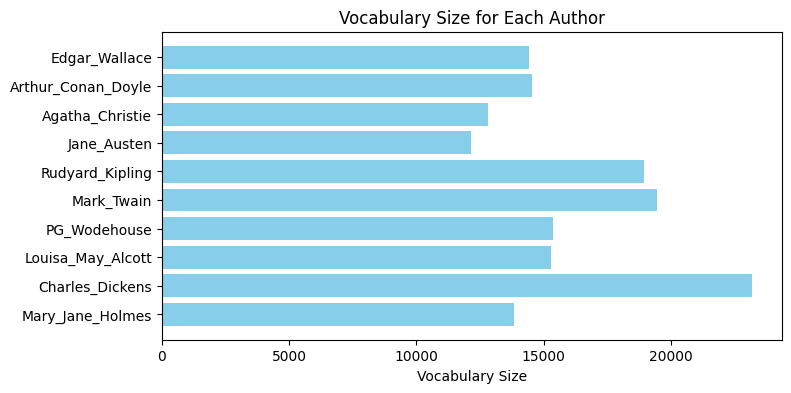

In [ ]:
# Data exploration - author vocabulary size

# Get the unique vocabulary size for each author in the preprocessed data
vocab_sizes = {}

for author, books in preprocessed_books.items():
    # Combine all books of the author and get unique words
    vocab = set([word for book in books for word in book])
    vocab_sizes[author] = len(vocab)

# Get the authors and their respective vocabulary sizes
authors = list(vocab_sizes.keys())
sizes = list(vocab_sizes.values())

# Create a bar plot
plt.figure(figsize=(8,4))
plt.barh(authors, sizes, color='skyblue')
plt.xlabel('Vocabulary Size')
plt.title('Vocabulary Size for Each Author')

# Display the plot
plt.show()

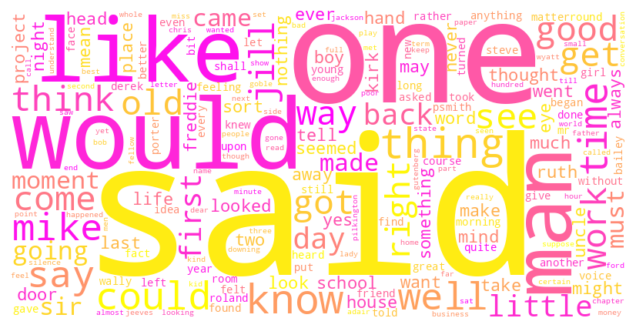

In [ ]:
# Data exploration - word cloud for a specific author

author = 'PG_Wodehouse'
all_words = [word for book in preprocessed_books[author] for word in book]
word_counts = Counter(all_words)

# Create a word cloud from the most frequent words
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='spring'
).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

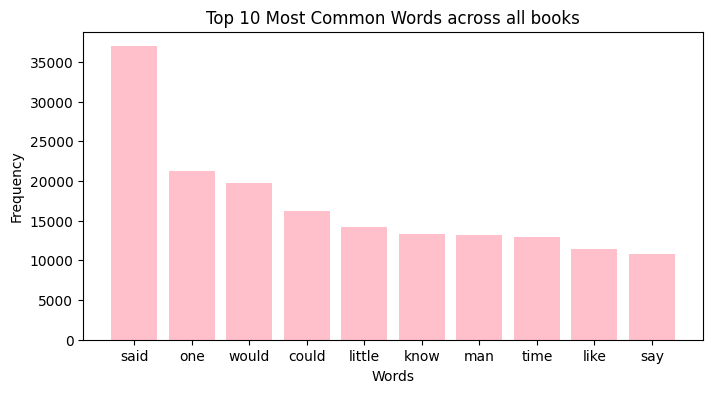

In [ ]:
# Data exploration - 10 most common words across all the books

# Get the most common words across all authors in the preprocessed data
all_words = [word for books in preprocessed_books.values() for book in books for word in book]
word_counts = Counter(all_words)

# Get the 10 most common words across all books
most_common_words = word_counts.most_common(10)

# Unpack the most common words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(words, counts, color='pink')
plt.title("Top 10 Most Common Words across all books")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#  Vectorizing using Bag of Words (BoW)

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=1000)

# Fit and transform the raw text data (chunked_texts) into a BoW matrix
X_bow = vectorizer.fit_transform(chunked_texts)

# Show the shape of the resulting BoW matrix (it will show number of samples and features)
print(f"Shape of BoW matrix: {X_bow.shape}")

# Labels (authors)
y = chunked_labels  # List of labels (authors)

# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Output the number of samples in the training and testing sets
print(f"Training set: {X_train_bow.shape[0]} samples")
print(f"Testing set: {X_test_bow.shape[0]} samples")


Shape of BoW matrix: (2947, 1000)
Training set: 2357 samples
Testing set: 590 samples


In [ ]:
# BoW - GridSearchCV using Logistic Regression

# Define Logistic Regression model
bow_lr = LogisticRegression(max_iter=10000, random_state=42)

# Define hyperparameters for GridSearchCV
bow_lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'penalty': ['l2'],  # Regularization type
}

# Use Stratified K-Folds cross-validation
bow_lr_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
bow_lr_grid_search = GridSearchCV(estimator=bow_lr, param_grid=bow_lr_param_grid, cv=bow_lr_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training data
bow_lr_grid_search.fit(X_train_bow, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (BoW - Logistic Regression):", bow_lr_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_bow_lr = bow_lr_grid_search.best_estimator_
bow_lr_y_pred = best_bow_lr.predict(X_test_bow)

# Evaluate the model's performance
accuracy_bow_lr = accuracy_score(y_test, bow_lr_y_pred)
print(f"Accuracy on Test Set (BoW - Logistic Regression): {accuracy_bow_lr:.4f}")
print("\nClassification Report (BoW - Logistic Regression):")
print(classification_report(y_test, bow_lr_y_pred))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters (BoW - Logistic Regression): {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set (BoW - Logistic Regression): 0.9661

Classification Report (BoW - Logistic Regression):
                    precision    recall  f1-score   support

   Agatha_Christie       1.00      1.00      1.00        34
Arthur_Conan_Doyle       1.00      0.97      0.99        36
   Charles_Dickens       1.00      0.97      0.99       155
     Edgar_Wallace       0.97      0.91      0.94        35
       Jane_Austen       1.00      0.98      0.99        58
 Louisa_May_Alcott       0.97      0.96      0.97        74
        Mark_Twain       0.95      0.96      0.95        55
  Mary_Jane_Holmes       0.98      0.94      0.96        49
      PG_Wodehouse       0.94      0.94      0.94        51
   Rudyard_Kipling       0.81      1.00      0.90        43

          accuracy                           0.97       590
      

In [ ]:
# BoW - GridSearchCV using Decision Tree

# Define Decision Tree model
bow_dt = DecisionTreeClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
bow_dt_param_grid = {
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Use Stratified K-Folds cross-validation
bow_dt_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
bow_dt_grid_search = GridSearchCV(estimator=bow_dt, param_grid=bow_dt_param_grid, cv=bow_dt_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training data
bow_dt_grid_search.fit(X_train_bow, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (BoW - Decision Tree):", bow_dt_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_bow_dt = bow_dt_grid_search.best_estimator_
bow_dt_y_pred = best_bow_dt.predict(X_test_bow)

# Evaluate the model's performance
accuracy_bow_dt = accuracy_score(y_test, bow_dt_y_pred)
print(f"Accuracy on Test Set (BoW - Decision Tree): {accuracy_bow_dt:.4f}")
print("\nClassification Report (BoW - Decision Tree):")
print(classification_report(y_test, bow_dt_y_pred))


Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best Hyperparameters (BoW - Decision Tree): {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy on Test Set (BoW - Decision Tree): 0.6271

Classification Report (BoW - Decision Tree):
                    precision    recall  f1-score   support

   Agatha_Christie       0.65      0.65      0.65        34
Arthur_Conan_Doyle       0.67      0.83      0.74        36
   Charles_Dickens       0.72      0.79      0.75       155
     Edgar_Wallace       0.49      0.51      0.50        35
       Jane_Austen       0.76      0.64      0.69        58
 Louisa_May_Alcott       0.75      0.61      0.67        74
        Mark_Twain       0.62      0.58      0.60        55
  Mary_Jane_Holmes       0.57      0.43      0.49        49
      PG_Wodehouse       0.57      0.39      0.47        51
   Rudyard_Kipling       0.31      0.51      0.39        43

          accuracy                           0.63

In [ ]:
# BoW - GridSearchCV using Random Forest

# Define Random Forest model
bow_rf = RandomForestClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
bow_rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 50, 100],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
}

# Use Stratified K-Folds cross-validation
bow_rf_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
bow_rf_grid_search = GridSearchCV(estimator=bow_rf, param_grid=bow_rf_param_grid, cv=bow_rf_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model
bow_rf_grid_search.fit(X_train_bow, y_train)

# Get the best hyperparameters
print("Best Hyperparameters (BoW - Random Forest):", bow_rf_grid_search.best_params_)

# Predict using best estimator
best_bow_rf = bow_rf_grid_search.best_estimator_
bow_rf_y_pred = best_bow_rf.predict(X_test_bow)

# Evaluate the model
accuracy_bow_rf = accuracy_score(y_test, bow_rf_y_pred)
print(f"Accuracy on Test Set (BoW - Random Forest): {accuracy_bow_rf:.4f}")
print("\nClassification Report (BoW - Random Forest):")
print(classification_report(y_test, bow_rf_y_pred))


Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Hyperparameters (BoW - Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy on Test Set (BoW - Random Forest): 0.9068

Classification Report (BoW - Random Forest):
                    precision    recall  f1-score   support

   Agatha_Christie       1.00      0.76      0.87        34
Arthur_Conan_Doyle       1.00      0.86      0.93        36
   Charles_Dickens       0.84      0.99      0.91       155
     Edgar_Wallace       1.00      0.86      0.92        35
       Jane_Austen       1.00      0.98      0.99        58
 Louisa_May_Alcott       0.99      0.93      0.96        74
        Mark_Twain       0.85      0.95      0.90        55
  Mary_Jane_Holmes       0.93      0.78      0.84        49
      PG_Wodehouse       0.95      0.76      0.85        51
   Rudyard_Kipling       0.80      0.93      0.86        43

          accuracy                           0.

In [ ]:
# BoW - GridSearchCV using KNN

# Define KNN model
bow_knn = KNeighborsClassifier()

# Define hyperparameters for GridSearchCV
bow_knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Use Stratified K-Folds cross-validation
bow_knn_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
bow_knn_grid_search = GridSearchCV(estimator=bow_knn, param_grid=bow_knn_param_grid, cv=bow_knn_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model
bow_knn_grid_search.fit(X_train_bow, y_train)

# Get the best hyperparameters
print("Best Hyperparameters (BoW - KNN):", bow_knn_grid_search.best_params_)

# Predict using best estimator
best_bow_knn = bow_knn_grid_search.best_estimator_
bow_knn_y_pred = best_bow_knn.predict(X_test_bow)

# Evaluate the model
accuracy_bow_knn = accuracy_score(y_test, bow_knn_y_pred)
print(f"Accuracy on Test Set (BoW - KNN): {accuracy_bow_knn:.4f}")
print("\nClassification Report (BoW - KNN):")
print(classification_report(y_test, bow_knn_y_pred))

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best Hyperparameters (BoW - KNN): {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy on Test Set (BoW - KNN): 0.8915

Classification Report (BoW - KNN):
                    precision    recall  f1-score   support

   Agatha_Christie       0.97      0.88      0.92        34
Arthur_Conan_Doyle       0.72      0.94      0.82        36
   Charles_Dickens       0.98      0.86      0.92       155
     Edgar_Wallace       0.86      0.89      0.87        35
       Jane_Austen       0.97      0.97      0.97        58
 Louisa_May_Alcott       0.97      0.93      0.95        74
        Mark_Twain       0.77      0.87      0.82        55
  Mary_Jane_Holmes       0.83      0.90      0.86        49
      PG_Wodehouse       0.89      0.80      0.85        51
   Rudyard_Kipling       0.80      0.91      0.85        43

          accuracy                           0.89       590
         macro avg       0.88      0.90  

In [ ]:
# BoW - GridSearchCV using Gradient Boosting

# Define Gradient Boosting model
bow_gb = GradientBoostingClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
bow_gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

# Use Stratified K-Folds cross-validation
bow_gb_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
bow_gb_grid_search = GridSearchCV(estimator=bow_gb, param_grid=bow_gb_param_grid, cv=bow_gb_cv, verbose=1, n_jobs=-1)

# Fit the model
bow_gb_grid_search.fit(X_train_bow, y_train)

# Best parameters
print("Best Hyperparameters (BoW - Gradient Boosting):", bow_gb_grid_search.best_params_)

# Predict on test set
best_bow_gb = bow_gb_grid_search.best_estimator_
bow_gb_y_pred = best_bow_gb.predict(X_test_bow)

# Evaluate
accuracy_bow_gb = accuracy_score(y_test, bow_gb_y_pred)
print(f"Accuracy on Test Set (BoW - Gradient Boosting): {accuracy_bow_gb:.4f}")
print("\nClassification Report (BoW - Gradient Boosting):")
print(classification_report(y_test, bow_gb_y_pred))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Hyperparameters (BoW - Gradient Boosting): {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy on Test Set (BoW - Gradient Boosting): 0.9373

Classification Report (BoW - Gradient Boosting):
                    precision    recall  f1-score   support

   Agatha_Christie       0.94      1.00      0.97        34
Arthur_Conan_Doyle       0.86      0.86      0.86        36
   Charles_Dickens       0.95      0.97      0.96       155
     Edgar_Wallace       0.91      0.83      0.87        35
       Jane_Austen       0.98      0.97      0.97        58
 Louisa_May_Alcott       0.97      0.92      0.94        74
        Mark_Twain       0.96      0.89      0.92        55
  Mary_Jane_Holmes       0.94      0.98      0.96        49
      PG_Wodehouse       0.96      0.88      0.92        51
   Rudyard_Kipling       0.82      0.98      0.89        43

          accuracy                           0.94       590
         macro avg   

<h3><strong>Bag of Words</strong></h3>
<table border="1">
    <thead>
        <tr>
            <th>Model</th>
            <th>Accuracy</th>
            <th>Macro Avg F1</th>
            <th>Weighted Avg F1</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Logistic Regression</td>
            <td>97%</td>
            <td>0.96</td>
            <td>0.97</td>
        </tr>
        <tr>
            <td>Gradient Boosting</td>
            <td>94%</td>
            <td>0.93</td>
            <td>0.94</td>
        </tr>
        <tr>
            <td>Random Forest</td>
            <td>91%</td>
            <td>0.90</td>
            <td>0.91</td>
        </tr>
        <tr>
            <td>KNN</td>
            <td>89%</td>
            <td>0.88</td>
            <td>0.89</td>
        </tr>
        <tr>
            <td>Decision Tree</td>
            <td>63%</td>
            <td>0.59</td>
            <td>0.63</td>
        </tr>
    </tbody>
</table>


In [ ]:
# Vectorization using  TF-IDF

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the raw text data (chunked_texts) into a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(chunked_texts)

# Show the shape of the resulting TF-IDF matrix
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

# Labels (authors)
y = chunked_labels  # List of labels (authors)

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Output the number of samples in the training and testing sets
print(f"Training set: {X_train_tfidf.shape[0]} samples")
print(f"Testing set: {X_test_tfidf.shape[0]} samples")


Shape of TF-IDF matrix: (2947, 1000)
Training set: 2357 samples
Testing set: 590 samples


In [ ]:
# TF-IDF - GridSearchCV using Logistic Regression

# Define Logistic Regression model
tfidf_lr = LogisticRegression(max_iter=10000, random_state=42)

# Define hyperparameters for GridSearchCV
tfidf_lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'penalty': ['l2'],  # Regularization type
}

# Use Stratified K-Folds cross-validation
tfidf_lr_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
tfidf_lr_grid_search = GridSearchCV(estimator=tfidf_lr, param_grid=tfidf_lr_param_grid, cv=tfidf_lr_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training data
tfidf_lr_grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (TF-IDF - Logistic Regression):", tfidf_lr_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_tfidf_lr = tfidf_lr_grid_search.best_estimator_
tfidf_lr_y_pred = best_tfidf_lr.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy_tfidf_lr = accuracy_score(y_test, tfidf_lr_y_pred)
print(f"Accuracy on Test Set (TF-IDF - Logistic Regression): {accuracy_tfidf_lr:.4f}")
print("\nClassification Report (TF-IDF - Logistic Regression):")
print(classification_report(y_test, tfidf_lr_y_pred))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters (TF-IDF - Logistic Regression): {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set (TF-IDF - Logistic Regression): 0.9695

Classification Report (TF-IDF - Logistic Regression):
                    precision    recall  f1-score   support

   Agatha_Christie       1.00      1.00      1.00        34
Arthur_Conan_Doyle       1.00      0.97      0.99        36
   Charles_Dickens       1.00      0.99      0.99       155
     Edgar_Wallace       1.00      0.91      0.96        35
       Jane_Austen       1.00      0.98      0.99        58
 Louisa_May_Alcott       0.99      0.95      0.97        74
        Mark_Twain       0.96      0.96      0.96        55
  Mary_Jane_Holmes       0.98      0.96      0.97        49
      PG_Wodehouse       0.96      0.94      0.95        51
   Rudyard_Kipling       0.78      1.00      0.88        43

          accuracy                           0.97       59

In [ ]:
# TF-IDF - GridSearchCV using Decision Tree

# Define Decision Tree model
tfidf_dt = DecisionTreeClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
tfidf_dt_param_grid = {
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Use Stratified K-Folds cross-validation
tfidf_dt_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
tfidf_dt_grid_search = GridSearchCV(estimator=tfidf_dt, param_grid=tfidf_dt_param_grid, cv=tfidf_dt_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training data
tfidf_dt_grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (TF-IDF - Decision Tree):", tfidf_dt_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_tfidf_dt = tfidf_dt_grid_search.best_estimator_
tfidf_dt_y_pred = best_tfidf_dt.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy_tfidf_dt = accuracy_score(y_test, tfidf_dt_y_pred)
print(f"Accuracy on Test Set (TF-IDF - Decision Tree): {accuracy_tfidf_dt:.4f}")
print("\nClassification Report (TF-IDF - Decision Tree):")
print(classification_report(y_test, tfidf_dt_y_pred))


Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best Hyperparameters (TF-IDF - Decision Tree): {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy on Test Set (TF-IDF - Decision Tree): 0.6186

Classification Report (TF-IDF - Decision Tree):
                    precision    recall  f1-score   support

   Agatha_Christie       0.68      0.76      0.72        34
Arthur_Conan_Doyle       0.60      0.69      0.64        36
   Charles_Dickens       0.74      0.70      0.72       155
     Edgar_Wallace       0.46      0.46      0.46        35
       Jane_Austen       0.74      0.83      0.78        58
 Louisa_May_Alcott       0.68      0.51      0.58        74
        Mark_Twain       0.54      0.51      0.52        55
  Mary_Jane_Holmes       0.58      0.43      0.49        49
      PG_Wodehouse       0.49      0.43      0.46        51
   Rudyard_Kipling       0.43      0.74      0.55        43

          accuracy                     

In [ ]:
# TF-IDF - GridSearchCV using Random Forest

# Define Random Forest model
tfidf_rf = RandomForestClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
tfidf_rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 50, 100],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
}

# Use Stratified K-Folds cross-validation
tfidf_rf_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
tfidf_rf_grid_search = GridSearchCV(estimator=tfidf_rf, param_grid=tfidf_rf_param_grid, cv=tfidf_rf_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model
tfidf_rf_grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
print("Best Hyperparameters (TF-IDF - Random Forest):", tfidf_rf_grid_search.best_params_)

# Predict using best estimator
best_tfidf_rf = tfidf_rf_grid_search.best_estimator_
tfidf_rf_y_pred = best_tfidf_rf.predict(X_test_tfidf)

# Evaluate the model
accuracy_tfidf_rf = accuracy_score(y_test, tfidf_rf_y_pred)
print(f"Accuracy on Test Set (TF-IDF - Random Forest): {accuracy_tfidf_rf:.4f}")
print("\nClassification Report (TF-IDF - Random Forest):")
print(classification_report(y_test, tfidf_rf_y_pred))

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Hyperparameters (TF-IDF - Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy on Test Set (TF-IDF - Random Forest): 0.9051

Classification Report (TF-IDF - Random Forest):
                    precision    recall  f1-score   support

   Agatha_Christie       1.00      0.82      0.90        34
Arthur_Conan_Doyle       0.94      0.89      0.91        36
   Charles_Dickens       0.83      0.99      0.90       155
     Edgar_Wallace       1.00      0.91      0.96        35
       Jane_Austen       1.00      0.98      0.99        58
 Louisa_May_Alcott       0.96      0.93      0.95        74
        Mark_Twain       0.91      0.93      0.92        55
  Mary_Jane_Holmes       0.93      0.80      0.86        49
      PG_Wodehouse       0.95      0.69      0.80        51
   Rudyard_Kipling       0.80      0.86      0.83        43

          accuracy                    

In [ ]:
# TF-IDF - GridSearchCV using KNN

# Define KNN model
tfidf_knn = KNeighborsClassifier()

# Define hyperparameters for GridSearchCV
tfidf_knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Use Stratified K-Folds cross-validation
tfidf_knn_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
tfidf_knn_grid_search = GridSearchCV(estimator=tfidf_knn, param_grid=tfidf_knn_param_grid, cv=tfidf_knn_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model
tfidf_knn_grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
print("Best Hyperparameters (TF-IDF - KNN):", tfidf_knn_grid_search.best_params_)

# Predict using best estimator
best_tfidf_knn = tfidf_knn_grid_search.best_estimator_
tfidf_knn_y_pred = best_tfidf_knn.predict(X_test_tfidf)

# Evaluate the model
accuracy_tfidf_knn = accuracy_score(y_test, tfidf_knn_y_pred)
print(f"Accuracy on Test Set (TF-IDF - KNN): {accuracy_tfidf_knn:.4f}")
print("\nClassification Report (TF-IDF - KNN):")
print(classification_report(y_test, tfidf_knn_y_pred))

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.91259748 0.91811387 0.90708325 0.9134471  0.90581062 0.91217375
 0.90071868 0.91090328        nan 0.10436606        nan 0.14592746
        nan 0.12387126        nan 0.09800294]
  warnings.warn(


Best Hyperparameters (TF-IDF - KNN): {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy on Test Set (TF-IDF - KNN): 0.9186

Classification Report (TF-IDF - KNN):
                    precision    recall  f1-score   support

   Agatha_Christie       0.92      0.97      0.94        34
Arthur_Conan_Doyle       0.87      0.92      0.89        36
   Charles_Dickens       0.97      0.95      0.96       155
     Edgar_Wallace       0.86      0.86      0.86        35
       Jane_Austen       0.97      0.97      0.97        58
 Louisa_May_Alcott       0.97      0.88      0.92        74
        Mark_Twain       0.84      0.84      0.84        55
  Mary_Jane_Holmes       0.94      0.96      0.95        49
      PG_Wodehouse       0.88      0.88      0.88        51
   Rudyard_Kipling       0.83      0.91      0.87        43

          accuracy                           0.92       590
         macro avg       0.90      0.91      0.91       590
      weighted avg       0.92    

In [ ]:
# TF-IDF - GridSearchCV using Gradient Boosting

# Define Gradient Boosting model
tfidf_gb = GradientBoostingClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
tfidf_gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

# Use Stratified K-Folds cross-validation
tfidf_gb_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV
tfidf_gb_grid_search = GridSearchCV(estimator=tfidf_gb, param_grid=tfidf_gb_param_grid, cv=tfidf_gb_cv, verbose=1, n_jobs=-1)

# Fit the model
tfidf_gb_grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Hyperparameters (TF-IDF - Gradient Boosting):", tfidf_gb_grid_search.best_params_)

# Predict on test set
best_tfidf_gb = tfidf_gb_grid_search.best_estimator_
tfidf_gb_y_pred = best_tfidf_gb.predict(X_test_tfidf)

# Evaluate
accuracy_tfidf_gb = accuracy_score(y_test, tfidf_gb_y_pred)
print(f"Accuracy on Test Set (TF-IDF - Gradient Boosting): {accuracy_tfidf_gb:.4f}")
print("\nClassification Report (TF-IDF - Gradient Boosting):")
print(classification_report(y_test, tfidf_gb_y_pred))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Hyperparameters (TF-IDF - Gradient Boosting): {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy on Test Set (TF-IDF - Gradient Boosting): 0.9288

Classification Report (TF-IDF - Gradient Boosting):
                    precision    recall  f1-score   support

   Agatha_Christie       0.94      0.97      0.96        34
Arthur_Conan_Doyle       0.86      0.83      0.85        36
   Charles_Dickens       0.95      0.97      0.96       155
     Edgar_Wallace       0.88      0.86      0.87        35
       Jane_Austen       0.97      0.98      0.97        58
 Louisa_May_Alcott       0.99      0.91      0.94        74
        Mark_Twain       0.89      0.89      0.89        55
  Mary_Jane_Holmes       0.98      0.92      0.95        49
      PG_Wodehouse       0.90      0.88      0.89        51
   Rudyard_Kipling       0.84      0.95      0.89        43

          accuracy                           0.93       590
         mac

<h3><strong>TF-IDF</strong></h3>
<table border="1" cellpadding="10">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Macro Avg F1</th>
      <th>Weighted Avg F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Logistic Regression</td>
      <td>97%</td>
      <td>0.97</td>
      <td>0.97</td>
    </tr>
    <tr>
      <td>Gradient Boosting</td>
      <td>93%</td>
      <td>0.92</td>
      <td>0.93</td>
    </tr>
    <tr>
      <td>KNN</td>
      <td>92%</td>
      <td>0.91</td>
      <td>0.92</td>
    </tr>
    <tr>
      <td>Random Forest</td>
      <td>91%</td>
      <td>0.90</td>
      <td>0.90</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>62%</td>
      <td>0.59</td>
      <td>0.62</td>
    </tr>
  </tbody>
</table>


In [ ]:
# Vectorization using Word2Vec

# === Step 1: Tokenize the input text ===
# Each chunk (assumed to be a string of text) is split into a list of words.
tokenized_chunks = [chunk.split() for chunk in chunked_texts]

# === Step 2: Train Word2Vec model ===
# Train a Word2Vec model using the tokenized chunks.
# - vector_size: size of the word vectors
# - window: context window size
# - min_count: include all words regardless of frequency (good for small datasets)
# - workers: number of worker threads to train the model in parallel
# - sg=1: use Skip-gram; use sg=0 for CBOW instead
w2v_model = Word2Vec(
    sentences=tokenized_chunks,
    vector_size=200,
    window=3,
    min_count=1,
    workers=4,
    sg=1
)

# Print the size of the vocabulary learned by the model
print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)}")

# === Step 3: Define function to average word vectors for a chunk ===
def get_avg_w2v_vector(words, model, vector_size):
    """
    Convert a list of words into a single averaged Word2Vec vector.
    Words not in the model's vocabulary are skipped.
    """
    vec = np.zeros(vector_size)  # Start with a zero vector
    count = 0  # Count of valid words found in the model

    for word in words:
        if word in model.wv:
            vec += model.wv[word]  # Add word vector to the sum
            count += 1

    if count > 0:
        vec /= count  # Take the average

    return vec

# === Step 4: Apply the function to all tokenized chunks ===
# Convert each tokenized chunk into a fixed-size vector by averaging its word vectors.
vector_size = w2v_model.vector_size
X_w2v = np.array([get_avg_w2v_vector(chunk, w2v_model, vector_size) for chunk in tokenized_chunks])

# Print the shape of the resulting matrix: (num_chunks, vector_size)
print(f"Shape of Word2Vec matrix: {X_w2v.shape}")

# === Step 5: Prepare labels and split the data ===
y = chunked_labels  # List of corresponding labels (authors)

# Split into training and test sets (80/20 split)
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Print the number of training and testing samples
print(f"Training set: {X_train_w2v.shape[0]} samples")
print(f"Testing set: {X_test_w2v.shape[0]} samples")

Vocabulary size: 46098
Shape of Word2Vec matrix: (2947, 200)
Training set: 2357 samples
Testing set: 590 samples


In [ ]:
# Word2Vec - GridSearchCV using Logistic Regression

# Define Logistic Regression model
w2v_lr = LogisticRegression(max_iter=10000, random_state=42)

# Define hyperparameters for GridSearchCV
w2v_lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'penalty': ['l2'],  # Regularization type
}

# Use Stratified K-Folds cross-validation
w2v_lr_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
w2v_lr_grid_search = GridSearchCV(estimator=w2v_lr, param_grid=w2v_lr_param_grid, cv=w2v_lr_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training data
w2v_lr_grid_search.fit(X_train_w2v, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (Word2Vec - Logistic Regression):", w2v_lr_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_w2v_lr = w2v_lr_grid_search.best_estimator_
w2v_lr_y_pred = best_w2v_lr.predict(X_test_w2v)

# Evaluate the model's performance
accuracy_w2v_lr = accuracy_score(y_test, w2v_lr_y_pred)
print(f"Accuracy on Test Set (Word2Vec - Logistic Regression): {accuracy_w2v_lr:.4f}")
print("\nClassification Report (Word2Vec - Logistic Regression):")
print(classification_report(y_test, w2v_lr_y_pred))


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters (Word2Vec - Logistic Regression): {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set (Word2Vec - Logistic Regression): 0.9458

Classification Report (Word2Vec - Logistic Regression):
                    precision    recall  f1-score   support

   Agatha_Christie       0.94      0.85      0.89        39
Arthur_Conan_Doyle       0.90      0.97      0.94        37
   Charles_Dickens       0.93      0.99      0.96       143
     Edgar_Wallace       0.93      0.90      0.92        30
       Jane_Austen       1.00      0.97      0.98        64
 Louisa_May_Alcott       0.95      0.98      0.97        64
        Mark_Twain       0.91      0.90      0.90        58
  Mary_Jane_Holmes       0.97      0.93      0.95        61
      PG_Wodehouse       0.93      0.89      0.91        47
   Rudyard_Kipling       0.98      0.96      0.97        47

          accuracy                           0.95   

In [ ]:
# Word2Vec - GridSearchCV using Decision Tree

# Define Decision Tree model
w2v_dt = DecisionTreeClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
w2v_dt_param_grid = {
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Use Stratified K-Folds cross-validation
w2v_dt_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
w2v_dt_grid_search = GridSearchCV(estimator=w2v_dt, param_grid=w2v_dt_param_grid, cv=w2v_dt_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the training Word2Vec data
w2v_dt_grid_search.fit(X_train_w2v, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (Word2Vec - Decision Tree):", w2v_dt_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_w2v_dt = w2v_dt_grid_search.best_estimator_
w2v_dt_y_pred = best_w2v_dt.predict(X_test_w2v)

# Evaluate the model's performance
accuracy_w2v_dt = accuracy_score(y_test, w2v_dt_y_pred)
print(f"Accuracy on Test Set (Word2Vec - Decision Tree): {accuracy_w2v_dt:.4f}")
print("\nClassification Report (Word2Vec - Decision Tree):")
print(classification_report(y_test, w2v_dt_y_pred))

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best Hyperparameters (Word2Vec - Decision Tree): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy on Test Set (Word2Vec - Decision Tree): 0.6390

Classification Report (Word2Vec - Decision Tree):
                    precision    recall  f1-score   support

   Agatha_Christie       0.62      0.67      0.64        39
Arthur_Conan_Doyle       0.53      0.51      0.52        37
   Charles_Dickens       0.67      0.67      0.67       143
     Edgar_Wallace       0.31      0.30      0.31        30
       Jane_Austen       0.92      0.84      0.88        64
 Louisa_May_Alcott       0.78      0.70      0.74        64
        Mark_Twain       0.64      0.71      0.67        58
  Mary_Jane_Holmes       0.63      0.56      0.59        61
      PG_Wodehouse       0.43      0.49      0.46        47
   Rudyard_Kipling       0.58      0.64      0.61        47

          accuracy             

In [ ]:
# Word2Vec - GridSearchCV using Random Forest

# Define Random Forest model
w2v_rf = RandomForestClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
w2v_rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 50, 100],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
}

# Use Stratified K-Folds cross-validation
w2v_rf_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
w2v_rf_grid_search = GridSearchCV(estimator=w2v_rf, param_grid=w2v_rf_param_grid, cv=w2v_rf_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the Word2Vec data
w2v_rf_grid_search.fit(X_train_w2v, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (Word2Vec - Random Forest):", w2v_rf_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_w2v_rf = w2v_rf_grid_search.best_estimator_
w2v_rf_y_pred = best_w2v_rf.predict(X_test_w2v)

# Evaluate the model's performance
accuracy_w2v_rf = accuracy_score(y_test, w2v_rf_y_pred)
print(f"Accuracy on Test Set (Word2Vec - Random Forest): {accuracy_w2v_rf:.4f}")
print("\nClassification Report (Word2Vec - Random Forest):")
print(classification_report(y_test, w2v_rf_y_pred))

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Hyperparameters (Word2Vec - Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy on Test Set (Word2Vec - Random Forest): 0.8678

Classification Report (Word2Vec - Random Forest):
                    precision    recall  f1-score   support

   Agatha_Christie       0.97      0.79      0.87        39
Arthur_Conan_Doyle       0.83      0.81      0.82        37
   Charles_Dickens       0.80      0.96      0.87       143
     Edgar_Wallace       0.96      0.87      0.91        30
       Jane_Austen       1.00      0.95      0.98        64
 Louisa_May_Alcott       0.87      0.94      0.90        64
        Mark_Twain       0.86      0.83      0.84        58
  Mary_Jane_Holmes       0.90      0.77      0.83        61
      PG_Wodehouse       0.78      0.68      0.73        47
   Rudyard_Kipling       0.89      0.85      0.87        47

          accuracy               

In [ ]:
# Word2Vec - GridSearchCV using KNN

# Define KNN model
w2v_knn = KNeighborsClassifier()

# Define hyperparameters for GridSearchCV
w2v_knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Use Stratified K-Folds cross-validation
w2v_knn_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
w2v_knn_grid_search = GridSearchCV(estimator=w2v_knn, param_grid=w2v_knn_param_grid, cv=w2v_knn_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the Word2Vec data
w2v_knn_grid_search.fit(X_train_w2v, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (Word2Vec - KNN):", w2v_knn_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_w2v_knn = w2v_knn_grid_search.best_estimator_
w2v_knn_y_pred = best_w2v_knn.predict(X_test_w2v)

# Evaluate the model's performance
accuracy_w2v_knn = accuracy_score(y_test, w2v_knn_y_pred)
print(f"Accuracy on Test Set (Word2Vec - KNN): {accuracy_w2v_knn:.4f}")
print("\nClassification Report (Word2Vec - KNN):")
print(classification_report(y_test, w2v_knn_y_pred))

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.86634989 0.87696038 0.87356695 0.88332422 0.87271373 0.88374723
 0.87356263 0.88162715        nan 0.8752633         nan 0.87611436
        nan 0.88162715        nan 0.88162859]
  warnings.warn(


Best Hyperparameters (Word2Vec - KNN): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy on Test Set (Word2Vec - KNN): 0.8898

Classification Report (Word2Vec - KNN):
                    precision    recall  f1-score   support

   Agatha_Christie       0.84      0.79      0.82        39
Arthur_Conan_Doyle       0.77      0.89      0.82        37
   Charles_Dickens       0.92      0.90      0.91       143
     Edgar_Wallace       0.93      0.93      0.93        30
       Jane_Austen       1.00      0.98      0.99        64
 Louisa_May_Alcott       0.89      0.91      0.90        64
        Mark_Twain       0.81      0.90      0.85        58
  Mary_Jane_Holmes       0.93      0.84      0.88        61
      PG_Wodehouse       0.87      0.85      0.86        47
   Rudyard_Kipling       0.85      0.85      0.85        47

          accuracy                           0.89       590
         macro avg       0.88      0.88      0.88       590
      weighted avg       0.

In [ ]:
# Word2Vec - GridSearchCV using Gradient Boosting

# Define Gradient Boosting model
w2v_gb = GradientBoostingClassifier(random_state=42)

# Define hyperparameters for GridSearchCV
w2v_gb_param_grid = {
    'n_estimators': [100, 200],      # Number of boosting stages to be used
    'learning_rate': [0.05, 0.1]     # Shrinks the contribution of each tree
}

# Use Stratified K-Folds cross-validation
w2v_gb_cv = StratifiedKFold(n_splits=4)

# Set up GridSearchCV with StratifiedKFold
w2v_gb_grid_search = GridSearchCV(estimator=w2v_gb, param_grid=w2v_gb_param_grid, cv=w2v_gb_cv, verbose=1, n_jobs=-1)

# Fit the GridSearchCV model to the Word2Vec data
w2v_gb_grid_search.fit(X_train_w2v, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters (Word2Vec - Gradient Boosting):", w2v_gb_grid_search.best_params_)

# Use the best estimator to predict on the test data
best_w2v_gb = w2v_gb_grid_search.best_estimator_
w2v_gb_y_pred = best_w2v_gb.predict(X_test_w2v)

# Evaluate the model's performance
accuracy_w2v_gb = accuracy_score(y_test, w2v_gb_y_pred)
print(f"Accuracy on Test Set (Word2Vec - Gradient Boosting): {accuracy_w2v_gb:.4f}")
print("\nClassification Report (Word2Vec - Gradient Boosting):")
print(classification_report(y_test, w2v_gb_y_pred))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Hyperparameters (Word2Vec - Gradient Boosting): {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy on Test Set (Word2Vec - Gradient Boosting): 0.8864

Classification Report (Word2Vec - Gradient Boosting):
                    precision    recall  f1-score   support

   Agatha_Christie       0.89      0.79      0.84        39
Arthur_Conan_Doyle       0.77      0.81      0.79        37
   Charles_Dickens       0.84      0.98      0.91       143
     Edgar_Wallace       0.80      0.93      0.86        30
       Jane_Austen       0.98      0.94      0.96        64
 Louisa_May_Alcott       0.94      0.91      0.92        64
        Mark_Twain       0.98      0.79      0.88        58
  Mary_Jane_Holmes       0.94      0.84      0.89        61
      PG_Wodehouse       0.86      0.79      0.82        47
   Rudyard_Kipling       0.88      0.89      0.88        47

          accuracy                           0.89       590
      

<h3><strong>Word2Vec</strong></h3>
<table border="1" cellpadding="10">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Macro Avg F1</th>
      <th>Weighted Avg F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Logistic Regression</td>
      <td>95%</td>
      <td>0.94</td>
      <td>0.95</td>
    </tr>
    <tr>
      <td>KNN</td>
      <td>89%</td>
      <td>0.88</td>
      <td>0.89</td>
    </tr>
    <tr>
      <td>Gradient Boosting</td>
      <td>89%</td>
      <td>0.87</td>
      <td>0.89</td>
    </tr>
    <tr>
      <td>Random Forest</td>
      <td>87%</td>
      <td>0.86</td>
      <td>0.87</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>64%</td>
      <td>0.61</td>
      <td>0.64</td>
    </tr>
  </tbody>
</table>


In [ ]:
# Author classification using LSTM

max_vocab_size_lstm = 5000  # Max number of unique words to keep
max_seq_len_lstm = 500      # All sequences will be padded/truncated to this length

# Initialize the tokenizer
tokenizer_lstm = Tokenizer(num_words=max_vocab_size_lstm, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(chunked_texts)

# Convert text to sequences of integers
sequences_lstm = tokenizer_lstm.texts_to_sequences(chunked_texts)

# Pad sequences to ensure uniform length
X_lstm = pad_sequences(sequences_lstm, maxlen=max_seq_len_lstm, padding='post', truncating='post')

print(f"Shape of padded sequences (LSTM): {X_lstm.shape}")

# Label encoding (converting author labels into integers)
label_encoder_lstm = LabelEncoder()
y_lstm = label_encoder_lstm.fit_transform(chunked_labels)

# Split the data into training and testing sets (80% train, 20% test)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Check how many samples in training and testing sets
print(f"Training set (LSTM): {X_train_lstm.shape[0]} samples")
print(f"Testing set (LSTM): {X_test_lstm.shape[0]} samples")

# Building the LSTM Model
model_lstm = Sequential()  # Model architecture

model_lstm.add(Input(shape=(max_seq_len_lstm,)))                              # Define input shape explicitly for the first layer
model_lstm.add(Embedding(input_dim=max_vocab_size_lstm, output_dim=128))      # Embedding layer: Convert word indices into dense vectors (500 words, 128-dim vectors)
model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))              # Bidirectional LSTM layer: process the input sequence in both forward and backward directions
model_lstm.add(Dropout(0.5))                                                  # Dropout layer: Prevents overfitting
model_lstm.add(Dense(64, activation='relu'))                                  # Dense layer: Intermediate layer with ReLU activation
model_lstm.add(Dense(len(label_encoder_lstm.classes_), activation='softmax')) # Output layer: 10 authors, using softmax for multi-class classification

# Compile the model
optimizer = Adam(learning_rate=0.0007)
model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)

# Train the Model
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm,
                              epochs=20,
                              batch_size=32,
                              validation_split=0.1,
                              callbacks=[early_stop, lr_scheduler])

# Get predictions
y_pred_probs_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)  # Convert probabilities to class labels

# Evaluate the model's performance
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
print(f"Accuracy on Test Set (LSTM): {accuracy_lstm:.4f}")
print("\nClassification Report (LSTM):")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=label_encoder_lstm.classes_))

Shape of padded sequences (LSTM): (2947, 500)
Training set (LSTM): 2357 samples
Testing set (LSTM): 590 samples
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2055 - loss: 2.2560 - val_accuracy: 0.2458 - val_loss: 2.1735 - learning_rate: 7.0000e-04
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2463 - loss: 2.1879 - val_accuracy: 0.2458 - val_loss: 2.1058 - learning_rate: 7.0000e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2889 - loss: 1.9471 - val_accuracy: 0.3136 - val_loss: 1.7887 - learning_rate: 7.0000e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3653 - loss: 1.6900 - val_accuracy: 0.2966 - val_loss: 1.7175 - learning_rate: 7.0000e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3946 - loss: 1.5242 - val_accuracy: 0.4364 - val_loss: 1.4200 - learning_rate: 7.0000e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5678 - loss: 1.1948 - val_accuracy: 0.5339 - val

In [ ]:
# Author classification using BERT

# Initialize the tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the dataset
label_encoder_bert = LabelEncoder()
encoded_labels = label_encoder_bert.fit_transform(chunked_labels)

data = {'text': chunked_texts, 'author': encoded_labels}
df = Dataset.from_dict(data)

# Train/test split
split_datasets = df.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

# Tokenization function
def tokenize_function(examples):
    return tokenizer_bert(examples['text'], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format datasets for training
def format_dataset(example):
    return {
        'input_ids': example['input_ids'],
        'attention_mask': example['attention_mask'],
        'labels': example['author']
    }

train_dataset = train_dataset.map(format_dataset)
test_dataset = test_dataset.map(format_dataset)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load pre-trained BERT model
num_labels = len(label_encoder_bert.classes_)
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    load_best_model_at_end=True
)

# Trainer setup
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# Train the model
trainer.train()

# Evaluate and predict
predictions_bert = trainer.predict(test_dataset)
y_pred_probs_bert = predictions_bert.predictions
y_pred_bert = np.argmax(y_pred_probs_bert, axis=1)
y_test_bert = predictions_bert.label_ids

# Report performance
accuracy_bert = accuracy_score(y_test_bert, y_pred_bert)
print(f"\n🔍 Accuracy on Test Set (BERT): {accuracy_bert:.4f}")
print("\n📊 Classification Report (BERT):")
print(classification_report(y_test_bert, y_pred_bert, target_names=label_encoder_bert.classes_))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2357 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/2357 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.984700,1.125462,0.677966
2,1.138200,0.447573,0.891525
3,0.229400,0.196308,0.947458
4,0.129100,0.220375,0.944068
5,0.069400,0.187504,0.957627



🔍 Accuracy on Test Set (BERT): 0.9576

📊 Classification Report (BERT):
                    precision    recall  f1-score   support

   Agatha_Christie       0.94      0.97      0.95        31
Arthur_Conan_Doyle       0.89      0.91      0.90        35
   Charles_Dickens       0.98      0.98      0.98       146
     Edgar_Wallace       0.97      1.00      0.99        33
       Jane_Austen       0.99      0.99      0.99        67
 Louisa_May_Alcott       0.95      1.00      0.97        74
        Mark_Twain       0.96      0.84      0.90        63
  Mary_Jane_Holmes       0.94      1.00      0.97        58
      PG_Wodehouse       0.98      0.93      0.95        45
   Rudyard_Kipling       0.92      0.89      0.91        38

          accuracy                           0.96       590
         macro avg       0.95      0.95      0.95       590
      weighted avg       0.96      0.96      0.96       590



<h3><strong>LSTM vs BERT</strong></h3>
<table border="1" cellpadding="10">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Macro Avg F1</th>
      <th>Weighted Avg F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>LSTM (Bidirectional)</td>
      <td>80%</td>
      <td>0.76</td>
      <td>0.80</td>
    </tr>
    <tr>
      <td>BERT (Pretrained Transformer)</td>
      <td>96%</td>
      <td>0.95</td>
      <td>0.96</td>
    </tr>
  </tbody>
</table>

In [ ]:
# Topic Modeling - LSA

# Create a dictionary and corpus for Gensim
dictionary = Dictionary([text.split() for text in chunked_texts])
corpus = [dictionary.doc2bow(text.split()) for text in chunked_texts]

# Vectorize the chunked_texts
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(chunked_texts)

# Perform LSA using TruncatedSVD
n_topics = 10  # Number of topics you want
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(vectorized_data)  # vectorized_data is the TF-IDF matrix

# Extract top words for each topic and their loading
terms = vectorizer.get_feature_names_out()  # Get the feature names (words) from the vectorizer
top_n = 10  # Number of top words per topic
lsa_top_words = []
lsa_top_words_with_loadings = []

for topic_idx, topic in enumerate(lsa_model.components_):
    # Get indices of top n words based on their loading values
    top_words_idx = topic.argsort()[-top_n:][::-1]

    # Extract top words and their loadings
    top_words = [(terms[i], topic[i]) for i in top_words_idx]
    lsa_top_words.append([word for word, _ in top_words])
    lsa_top_words_with_loadings.append(top_words)

# Print the top words and their loadings for each topic
print("===== Topic Modeling - LSA =====")
for idx, (top_words, loadings) in enumerate(zip(lsa_top_words, lsa_top_words_with_loadings)):
    print(f"Topic {idx + 1}:")
    for word, loading in loadings:
        print(f"  {word}: {loading:.4f}")
    print()

# Calculate coherence for LSA
coherence_model_lsa = CoherenceModel(topics=lsa_top_words, texts=[text.split() for text in chunked_texts], dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print(f"LSA Coherence Score: {coherence_lsa}")


===== Topic Modeling - LSA =====
Topic 1:
  said: 0.2575
  one: 0.1562
  would: 0.1500
  could: 0.1279
  little: 0.1092
  man: 0.1010
  know: 0.1002
  time: 0.0970
  upon: 0.0922
  like: 0.0894

Topic 2:
  project: 0.5949
  work: 0.2443
  electronic: 0.2391
  gutenberg: 0.2175
  foundation: 0.2110
  donation: 0.2056
  agreement: 0.1458
  copyright: 0.1437
  archive: 0.1339
  copy: 0.1201

Topic 3:
  pickwick: 0.3919
  sam: 0.1947
  said: 0.1798
  weller: 0.1591
  winkle: 0.0987
  sir: 0.0941
  man: 0.0863
  poirot: 0.0718
  holmes: 0.0666
  dick: 0.0662

Topic 4:
  polly: 0.4263
  tom: 0.3482
  maud: 0.0882
  amy: 0.0847
  fan: 0.0772
  meg: 0.0728
  girl: 0.0723
  jill: 0.0722
  laurie: 0.0685
  jack: 0.0685

Topic 5:
  pickwick: 0.5277
  polly: 0.3963
  tom: 0.2949
  fanny: 0.2676
  sam: 0.2533
  weller: 0.2140
  winkle: 0.1310
  sir: 0.1104
  crawford: 0.1062
  maud: 0.0827

Topic 6:
  poirot: 0.3892
  fanny: 0.1656
  holmes: 0.1481
  tom: 0.1098
  polly: 0.1016
  crawford: 0.1001
 

In [ ]:
# Topic Modeling - LDA

# Create a dictionary and corpus for Gensim
dictionary = Dictionary([text.split() for text in chunked_texts])
corpus = [dictionary.doc2bow(text.split()) for text in chunked_texts]

# Vectorize the chunked_texts
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(chunked_texts)

# Perform LDA using Gensim's LdaModel
n_topics = 10  # Number of topics you want
lda_model = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=15)

# Extract top words for each topic
top_n = 10  # Number of top words per topic
lda_top_words = []
lda_top_words_with_loadings = []

for topic_id in range(n_topics):
    top_words = lda_model.show_topic(topic_id, topn=top_n)  # Get the top n words for this topic
    lda_top_words.append([word for word, _ in top_words])
    lda_top_words_with_loadings.append(top_words)

# Print the top words and their loadings for each topic
print("===== Topic Modeling - LDA =====")
for idx, (top_words, loadings) in enumerate(zip(lda_top_words, lda_top_words_with_loadings)):
    print(f"Topic {idx + 1}:")
    for word, loading in loadings:
        print(f"  {word}: {loading:.4f}")
    print()

# Calculate coherence for LDA
coherence_model_lda = CoherenceModel(topics=lda_top_words, texts=[text.split() for text in chunked_texts], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"LDA Coherence Score: {coherence_lda}")


===== Topic Modeling - LDA =====
Topic 1:
  said: 0.0150
  one: 0.0078
  mike: 0.0065
  would: 0.0063
  say: 0.0061
  man: 0.0059
  thing: 0.0055
  like: 0.0054
  know: 0.0044
  time: 0.0042

Topic 2:
  could: 0.0123
  would: 0.0119
  miss: 0.0073
  must: 0.0071
  much: 0.0066
  said: 0.0060
  one: 0.0058
  think: 0.0056
  know: 0.0051
  never: 0.0049

Topic 3:
  said: 0.0111
  one: 0.0097
  man: 0.0084
  would: 0.0056
  upon: 0.0053
  could: 0.0050
  two: 0.0045
  time: 0.0042
  hand: 0.0040
  see: 0.0038

Topic 4:
  said: 0.0132
  eloise: 0.0087
  colonel: 0.0067
  ann: 0.0067
  like: 0.0066
  miss: 0.0062
  one: 0.0061
  jack: 0.0059
  man: 0.0058
  know: 0.0055

Topic 5:
  said: 0.0135
  would: 0.0082
  one: 0.0070
  upon: 0.0070
  could: 0.0062
  time: 0.0059
  hand: 0.0058
  little: 0.0054
  know: 0.0054
  never: 0.0048

Topic 6:
  said: 0.0215
  sir: 0.0082
  say: 0.0071
  pickwick: 0.0059
  little: 0.0058
  old: 0.0056
  one: 0.0052
  know: 0.0051
  gentleman: 0.0051
  man: 0.0

In [ ]:
# Topic Modeling - NMF

# Create a dictionary and corpus for Gensim
dictionary = Dictionary([text.split() for text in chunked_texts])
corpus = [dictionary.doc2bow(text.split()) for text in chunked_texts]

# Vectorize the chunked_texts
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(chunked_texts)

# Perform NMF using scikit-learn's NMF
n_topics = 10  # Number of topics you want
nmf_model = NMF(n_components=n_topics, init='random', random_state=42)
nmf_topic_matrix = nmf_model.fit_transform(vectorized_data)  # vectorized_data is the TF-IDF matrix

# Extract top words for each topic
top_n = 10  # Number of top words per topic
nmf_top_words = []
nmf_top_words_with_loadings = []

terms = vectorizer.get_feature_names_out()  # Get the feature names (words) from the vectorizer

for topic_idx, topic in enumerate(nmf_model.components_):
    # Get indices of top n words based on their loading values
    top_words_idx = topic.argsort()[-top_n:][::-1]

    # Extract top words and their loadings
    top_words = [(terms[i], topic[i]) for i in top_words_idx]
    nmf_top_words.append([word for word, _ in top_words])
    nmf_top_words_with_loadings.append(top_words)

# Print the top words and their loadings for each topic
print("===== Topic Modeling - NMF =====")
for idx, (top_words, loadings) in enumerate(zip(nmf_top_words, nmf_top_words_with_loadings)):
    print(f"Topic {idx + 1}:")
    for word, loading in loadings:
        print(f"  {word}: {loading:.4f}")
    print()

# Calculate coherence for NMF
coherence_model_nmf = CoherenceModel(topics=nmf_top_words, texts=[text.split() for text in chunked_texts], dictionary=dictionary, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print(f"NMF Coherence Score: {coherence_nmf}")


===== Topic Modeling - NMF =====
Topic 1:
  said: 3.0420
  one: 1.7986
  would: 1.5171
  man: 1.4294
  upon: 1.3973
  could: 1.1855
  time: 1.0852
  know: 1.0452
  sir: 1.0364
  little: 1.0194

Topic 2:
  project: 2.6885
  work: 1.1179
  electronic: 1.0790
  gutenberg: 0.9841
  foundation: 0.9530
  donation: 0.9259
  agreement: 0.6594
  copyright: 0.6489
  archive: 0.6031
  copy: 0.5445

Topic 3:
  poirot: 4.3588
  inglethorp: 0.9981
  hastings: 0.7718
  cavendish: 0.4450
  monsieur: 0.4409
  japp: 0.4279
  madame: 0.3852
  said: 0.3620
  one: 0.3568
  john: 0.3341

Topic 4:
  pickwick: 4.2791
  sam: 2.0873
  weller: 1.7302
  said: 1.1735
  winkle: 1.0742
  sir: 0.9923
  replied: 0.7474
  gentleman: 0.6322
  wery: 0.6164
  tupman: 0.5842

Topic 5:
  dick: 3.8829
  gilder: 1.1113
  maisie: 1.0850
  said: 1.0285
  leslie: 0.8833
  torpenhow: 0.8596
  arthur: 0.8464
  harry: 0.7834
  gwyn: 0.6920
  puttler: 0.5901

Topic 6:
  fanny: 1.5613
  emma: 1.4329
  crawford: 1.1644
  elinor: 0.954

<h3><strong>Topic Modeling</strong></h3>
<table border="1">
    <thead>
        <tr>
            <th>Model</th>
            <th>Coherence Score</th>
        </tr>
    </thead>
    <tbody>    
        <tr>
            <td>LSA (Latent Semantic Analysis)</td>
            <td>0.4313</td>
        </tr>
        <tr>
            <td>LDA (Latent Dirichlet Allocation)</td>
            <td>0.4393</td>
        </tr>
        <tr>
            <td>NMF (Non-negative Matrix Factorization)</td>
            <td>0.6456</td>
        </tr>
    </tbody>
</table>


<h2><Strong>Analysis and conclusions: </Strong></h2>

<details>
<summary><strong>Traditional Machine Learning Models</strong></summary>
<br>

<table border="1" cellspacing="0" cellpadding="8">
  <thead>
    <tr>
      <th>Model</th>
      <th>Bag of Words</th>
      <th>TF-IDF</th>
      <th>Word2Vec</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Logistic Regression</td>
      <td>97%</td>
      <td>97%</td>
      <td>95%</td>
    </tr>
    <tr>
      <td>Gradient Boosting</td>
      <td>94%</td>
      <td>93%</td>
      <td>89%</td>
    </tr>
    <tr>
      <td>Random Forest</td>
      <td>91%</td>
      <td>91%</td>
      <td>87%</td>
    </tr>
    <tr>
      <td>KNN</td>
      <td>89%</td>
      <td>92%</td>
      <td>89%</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>63%</td>
      <td>62%</td>
      <td>64%</td>
    </tr>
  </tbody>
</table>

<br>

<div>
   <strong>📦 Bag of Words (BoW):</strong>
      <ul>
        <li>Best overall performance.</li>
        <li>Top accuracy with Logistic Regression (<strong>97%</strong>).</li>
      </ul>
      <strong>📊 TF-IDF:</strong>
      <ul>
        <li>Very similar to BoW in results.</li>
        <li>Improves performance for KNN and Gradient Boosting.</li>
      </ul>
      <strong>🧠 Word2Vec:</strong>
      <ul>
        <li>Slightly lower accuracy across all models.</li>
        <li>Logistic Regression still strong (<strong>95%</strong>), but not the best.</li>
      </ul>
  <br>  
  <p><strong>🔑 Takeaway:</strong> Use <strong>BoW or TF-IDF with Logistic Regression</strong> for best performance.</p>
</div>

</details>

<details>

<summary><strong>Deep Learning Models</strong></summary>
<br>

<table border="1" cellpadding="10">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>LSTM (Bidirectional)</td>
      <td>80%</td>
    </tr>
    <tr>
      <td>BERT (Pretrained Transformer)</td>
      <td>96%</td>
    </tr>
  </tbody>
</table>

<br>

<div>
    <strong>📘 LSTM (Bidirectional):</strong>
    <ul>
      <li>Solid performance with <strong>~80% accuracy</strong>.</li>
      <li>Lightweight and fast – good for limited compute resources.</li>
    </ul>
    <strong>🤖 BERT (Pretrained Transformer):</strong>
    <ul>
      <li>Top performance with <strong>95.76% accuracy</strong>.</li>
      <li>Requires more compute but delivers the best results.</li>
    </ul>
    <br>
  <p><strong>🔑 Takeaway:</strong>  
    Choose <strong>BERT</strong> for highest accuracy.  
    Go with <strong>LSTM</strong> when speed or resource efficiency matters.
  </p>
</div>

</details>

<details>
<summary><strong>Topic Modeling </strong></summary>
<br>

<table border="1">
    <thead>
        <tr>
            <th>Model</th>
            <th>Coherence Score</th>
            <th>Topic Clarity</th>
            <th>Redundancy</th>
            <th>Best Use</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>LSA (Latent Semantic Analysis)</td>
            <td>0.4313</td>
            <td>Moderate</td>
            <td>Medium</td>
            <td>General semantics</td>
        </tr>
        <tr>
            <td>LDA (Latent Dirichlet Allocation)</td>
            <td>0.4393</td>
            <td>Low</td>
            <td>High</td>
            <td>Metadata or long-form topics</td>
        </tr>
        <tr>
            <td>NMF (Non-negative Matrix Factorization)</td>
            <td>0.6456</td>
            <td>High</td>
            <td>Low</td>
            <td>Character/theme-rich text</td>
        </tr>
    </tbody>
</table>

<br>

<div>
    <strong>📊 NMF (Non-negative Matrix Factorization):</strong>
    <ul>
        <li>Highly interpretable topics with <strong>clear character or theme separation</strong>.</li>
        <li><strong>Highest coherence score (0.6456)</strong> — best for narrative text.</li>
    </ul>
    <strong>🧠 LSA (Latent Semantic Analysis):</strong>
    <ul>
        <li>Moderately clear topics with <strong>some character overlap</strong>.</li>
        <li>Better than LDA, but still lacks sharp separation.</li>
    </ul>
    <strong>📚 LDA (Latent Dirichlet Allocation):</strong>
    <ul>
        <li>Mostly <strong>generic and redundant topics</strong>.</li>
        <li>Only one coherent topic (legal/boilerplate), <strong>low interpretability</strong>.</li>
    </ul>
    <br>
    <p><strong>🔑 Takeaway:</strong>  
        Choose <strong>NMF</strong> for best topic coherence and clarity in literary or narrative texts.  
        Use <strong>LSA</strong> as a secondary option.  
        Avoid <strong>LDA</strong> for this type of data.
    </p>
</div>

</Details>